# Geographical plots:

## Set-up:

### Imports:

In [7]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
import os
from sklearn.decomposition import PCA
import matplotlib.collections as mcoll
import matplotlib.path as mpath

### Constants:

Constants for plots:

In [8]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Constants for data:

In [9]:
# Percentage of nearest neighbours:
PERC_NEIGH = 10
print(f'Percentage of nearest neighbours: {PERC_NEIGH/100}')

# Number of eigenmaps to compute:
NUM_EIGENVALUES = 20
print(f'Number of eigenmaps: {NUM_EIGENVALUES}')

# Path to input data:
INPUT_DATA = '../../../data/vandermeer/input_data/'
print(f'Path to input data: {INPUT_DATA}')

# Bandwitdh used for the heat kernel:
BDWTH = 'mean'
print(f'Bandwitdh used for the heat kernel: t_{BDWTH}')

Percentage of nearest neighbours: 0.1
Number of eigenmaps: 20
Path to input data: ../../../data/vandermeer/input_data/
Bandwitdh used for the heat kernel: t_mean


### Load data: 

In [10]:
%%time
print('Reading input data:')
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')
anomalies_cf = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1)
raw_cf = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')
raw_cf = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1)
basis_cf = pd.read_csv(INPUT_DATA + 'basis_functions.csv', sep=',')
basis_array = np.array(basis_cf.drop(['Unnamed: 0', 'Lon', 'Lat'], axis=1))

print(f'Basis shape: {basis_array.shape}')
print(f'Raw data shape: {raw_cf.values.shape}')
print(f'Anomalies data shape: {anomalies_cf.values.shape}')

Reading input data:
Basis shape: (38400, 1001)
Raw data shape: (33960, 1001)
Anomalies data shape: (33960, 1001)
CPU times: user 21.5 s, sys: 1.61 s, total: 23.1 s
Wall time: 23 s


### Functions:

Function that creates a correct path depending on the type of data:

In [11]:
def path_to_data(DATA, PERC_NEIGH, BDWTH):
    if DATA == 'raw':
        PATH = '../../../data/vandermeer/pickles/raw/'
    elif DATA == 'anomalies': 
        PATH = '../../../data/vandermeer/pickles/anomalies/'
    PATH1 = PATH + str(PERC_NEIGH)+f'perc/t_{BDWTH}/'
    if not os.path.exists(PATH1):
            os.makedirs(PATH1)
    print(f'Precise path: {PATH1}')
    return PATH1

Function that applies basis transformation:

In [12]:
def basis_transf(coordinates, basis):
    """
    @input: 
    - basis np.array of shape (38400, 1001) or (1001, 38400)
    - coordinates np.array of shape (1001, )
    @output: geographical sample for one time step of shape np.array (38400,)
    """
    x = np.zeros(38400)
    if coordinates.shape == (1, 1001):
        coordinates = coordinates.T
    if basis.shape == (38400, 1001):
        basis = basis.T
    for i in range(len(coordinates)):
        x += coordinates[i] * basis[i]
    return x

Function that applies the basis transformation to a sample point, returns array of shape (lat, lon) and containing the PV values for each pair of coordinates. Necessary for plotting with cartopy

In [13]:
def create_geo_sample(sample_array, basis_array):
    """
    @input: 
    - basis np.array of shape (38400, 1001) or (1001, 38400)
    - coordinates np.array of shape (1001, )
    @output: 
    - values_array: array of shape (lat, lon) and containing the PV values for each pair of coordinates
    - lat: latitude coordinates
    - lon: longitude coordinates
    """
    X_sample = pd.DataFrame(
        data={
            'longitude': basis_cf['Lon'],
            'latitude': basis_cf['Lat'],
            'PV_values': basis_transf(sample_array, basis_array)
        })
    df = X_sample.pivot(index='latitude',
                                  columns='longitude',
                                  values='PV_values')
    values_array = df.values
    lat = df.index
    lon = df.columns.values
    return values_array, lat, lon

Functions to plot color segments in gradients:

In [14]:
def colorline(
    x, y, ax,z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    #ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

Function to plot regions on eigenvector vs eigenvector plots:

In [15]:
def plot_regions(ax, regions, sample_trajectory,eigs, alpha = 0.8, traj = True):
    for i in range(len(regions)):
        ax.plot(regions[i]['1'],
                regions[i]['2'],alpha = alpha,
                linewidth=0.15,
                label=f'part {i+1}')
    if traj:
        colorline(sample_trajectory[0],
                  sample_trajectory[1],
                  ax,
                  cmap=plt.get_cmap('winter_r'),
                  linewidth=2)
    ax.plot(eigs[0], eigs[1],linewidth=0.15,alpha=0.5,color='grey')

## PCA versus Eigenmaps:

### Raw: 

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [8]:
# PCA:
pca = PCA(n_components=NUM_EIGENVALUES)
pca.fit(np.array(raw_cf))

singular_values_pca = pca.singular_values_
explained_variance_ratio__pca = pca.explained_variance_ratio_
components_pca = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".format(
    sv=singular_values_pca, ev=explained_variance_ratio__pca))

Singular values: [0.01351784 0.00915538 0.00739242 0.00563988 0.00541272 0.00479449
 0.00367113 0.00342344 0.00323525 0.0031639  0.00294812 0.0025928
 0.00243065 0.00231127 0.00225143 0.00220725 0.00199378 0.00196006
 0.00187615 0.0018402 ] 
Explained variance: [0.30223216 0.13863696 0.09038559 0.05260966 0.04845708 0.03801986
 0.02229081 0.01938435 0.01731174 0.01655662 0.01437526 0.01111898
 0.00977171 0.0088354  0.00838385 0.00805807 0.00657477 0.00635425
 0.00582183 0.00560086]


In [9]:
def plot_eigenvalues(w_mean,NUM_EIGENVALUES):
    fig, axs = plt.subplots(1, figsize=(10, 5))
    axs.scatter(x=range(0, NUM_EIGENVALUES),
                y=np.flip(w_mean),
                marker='o',
                alpha=0.7)
    #axs.set_title(f'Eigenvalues for heat and simple kernel')
    axs.set_ylabel('Singular value')
    axs.set_xlabel('Number of singular value')
    plt.locator_params(axis='x', nbins=21)

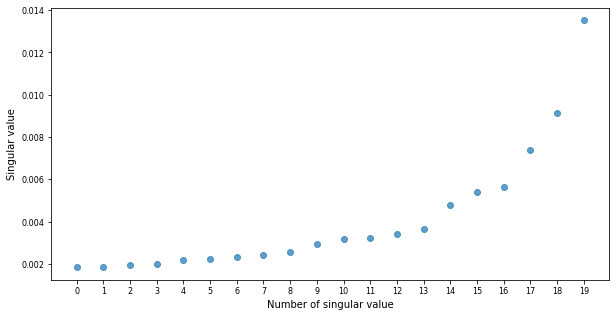

In [10]:
plot_eigenvalues(singular_values_pca,NUM_EIGENVALUES)

In [11]:
def multiplot_PCA_eigenmap(components_pca,
                           basis_array,
                           sign_PCA,
                           sign_eigenmap,m=0,n=0,
                           DATA='raw',
                           PERC_NEIGH=10,
                           BDWTH='mean',
                           NUM_EIGENVALUES=20):
    
    PATH1 = path_to_data(DATA, PERC_NEIGH, BDWTH)
    eigenvectors = np.zeros((NUM_EIGENVALUES, 1001))
    
    for i in range(NUM_EIGENVALUES):
        X_prime_i = np.load(PATH1 + f'X_prime_{i}.npy')
        eigenvectors[i] = np.real(X_prime_i)

    projection = ccrs.Orthographic(central_longitude=0.0,
                                   central_latitude=90.0)
    data_crs = ccrs.PlateCarree()

    fig = plt.figure(figsize=(15, 15))

    for i in range(1, 21):
        if i <= 5:
            values_array, lat, lon = create_geo_sample(
                np.multiply(components_pca[m], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('PCA eigenvector {}'.format(m + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_PCA[m] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            m += 1
        if 5 < i and i <= 10:
            values_array, lat, lon = create_geo_sample(
                np.multiply(eigenvectors[n], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('Laplacian eigenmap {}'.format(n + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_eigenmap[n] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            n += 1
        if 10 < i and i <= 15:
            values_array, lat, lon = create_geo_sample(
                np.multiply(components_pca[m], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('PCA eigenvector {}'.format(m + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_PCA[m] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            m += 1
        if 15 < i:
            values_array, lat, lon = create_geo_sample(
                np.multiply(eigenvectors[n], 1e6), basis_array)
            axi = plt.subplot(4, 5, i, projection=projection)
            plt.title('Laplacian eigenmap {}'.format(n + 1))
            axi.set_global()
            axi.coastlines()
            pcm = axi.contourf(lon,
                               lat,
                               sign_eigenmap[n] * values_array,
                               60,
                               transform=data_crs,
                               cmap='RdYlBu_r')
            n += 1
    plt.show()

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/


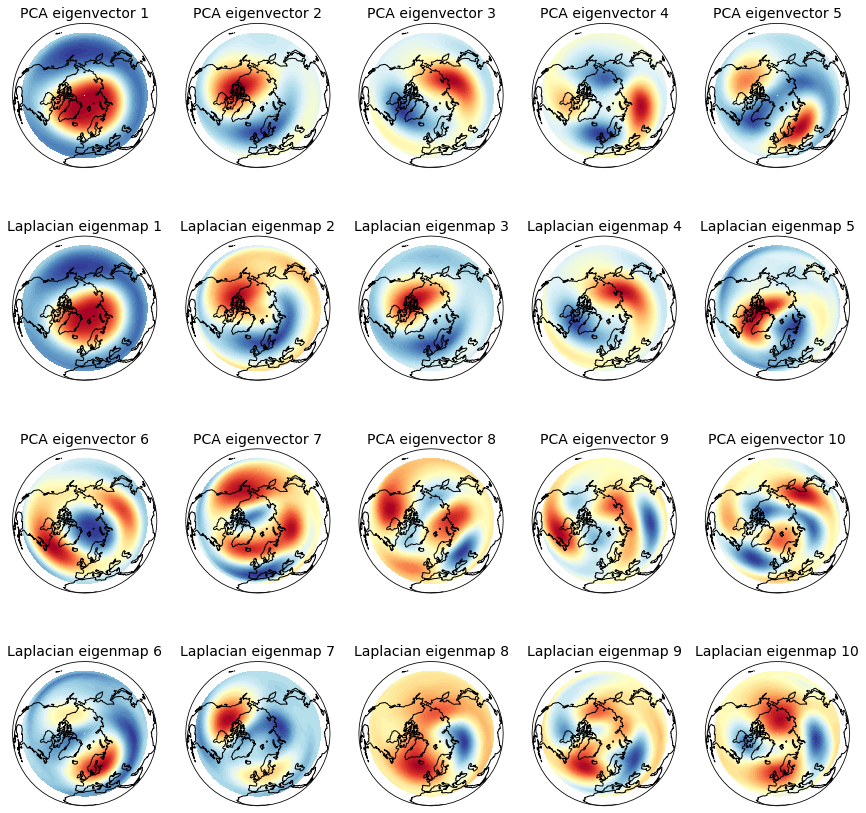

In [12]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
m,n = 0,0
multiplot_PCA_eigenmap(components_pca,
                       basis_array,sign_PCA, sign_eigenmap,m,n,
                       DATA='raw',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/


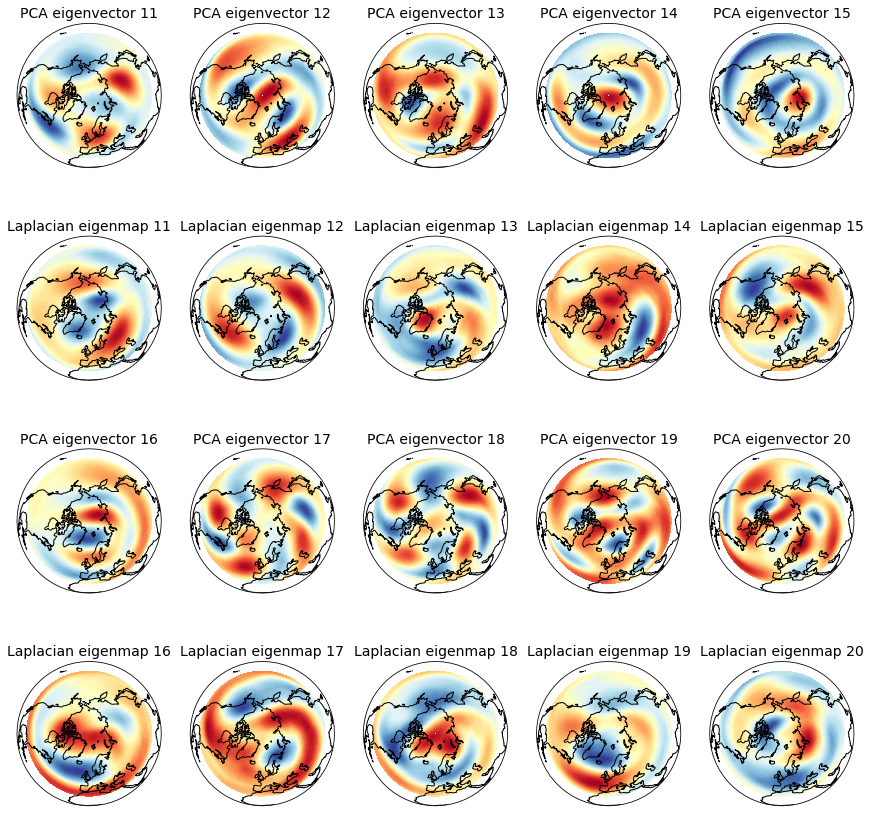

In [13]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1,-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
m,n = 10, 10
multiplot_PCA_eigenmap(components_pca,
                       basis_array,sign_PCA, sign_eigenmap,m,n,
                       DATA='raw',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

### Anomalies: 

In [14]:
# PCA:
pca = PCA(n_components=NUM_EIGENVALUES)
pca.fit(np.array(anomalies_cf))

singular_values_pca_an = pca.singular_values_
explained_variance_ratio__pca = pca.explained_variance_ratio_
components_pca_an = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".format(
    sv=singular_values_pca, ev=explained_variance_ratio__pca))

Singular values: [0.01351784 0.00915538 0.00739242 0.00563988 0.00541272 0.00479449
 0.00367113 0.00342344 0.00323525 0.0031639  0.00294812 0.0025928
 0.00243065 0.00231127 0.00225143 0.00220725 0.00199378 0.00196006
 0.00187615 0.0018402 ] 
Explained variance: [0.11793901 0.10424032 0.07995019 0.06031895 0.05119158 0.04125194
 0.03483436 0.03063228 0.02724685 0.02336679 0.02162972 0.01779005
 0.01733542 0.01486514 0.01467308 0.01427418 0.01248722 0.01069144
 0.0101311  0.00987854]


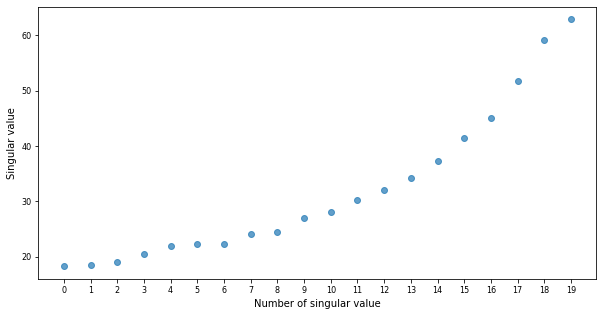

In [15]:
plot_eigenvalues(singular_values_pca_an,NUM_EIGENVALUES)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/


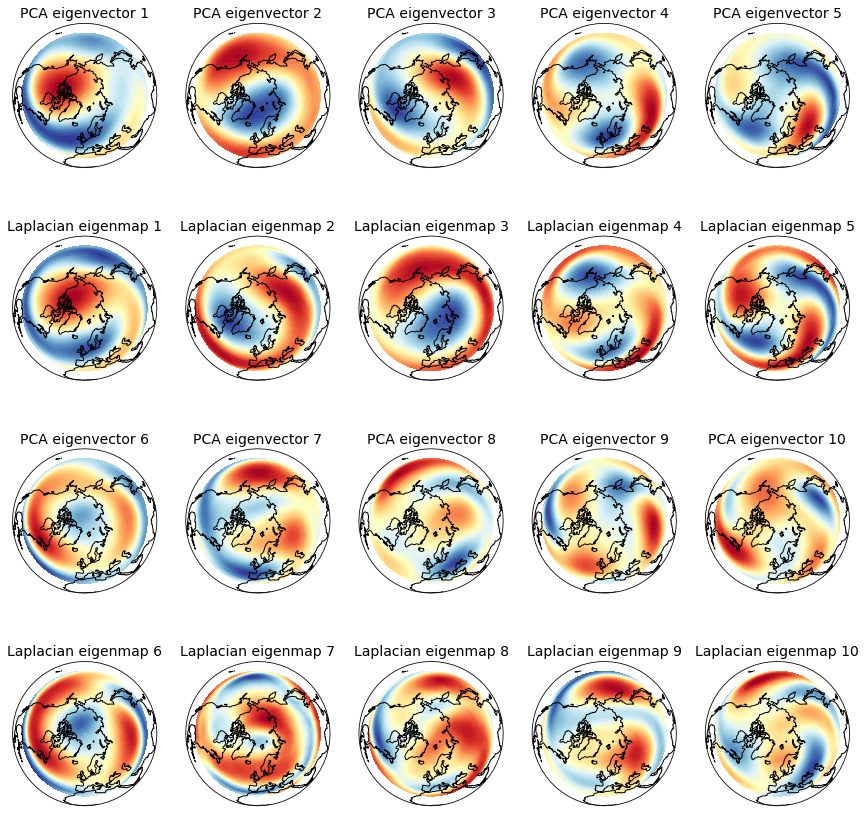

In [16]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
m,n = 0,0
multiplot_PCA_eigenmap(components_pca_an,
                       basis_array,sign_PCA, sign_eigenmap,m,n,
                       DATA='anomalies',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/


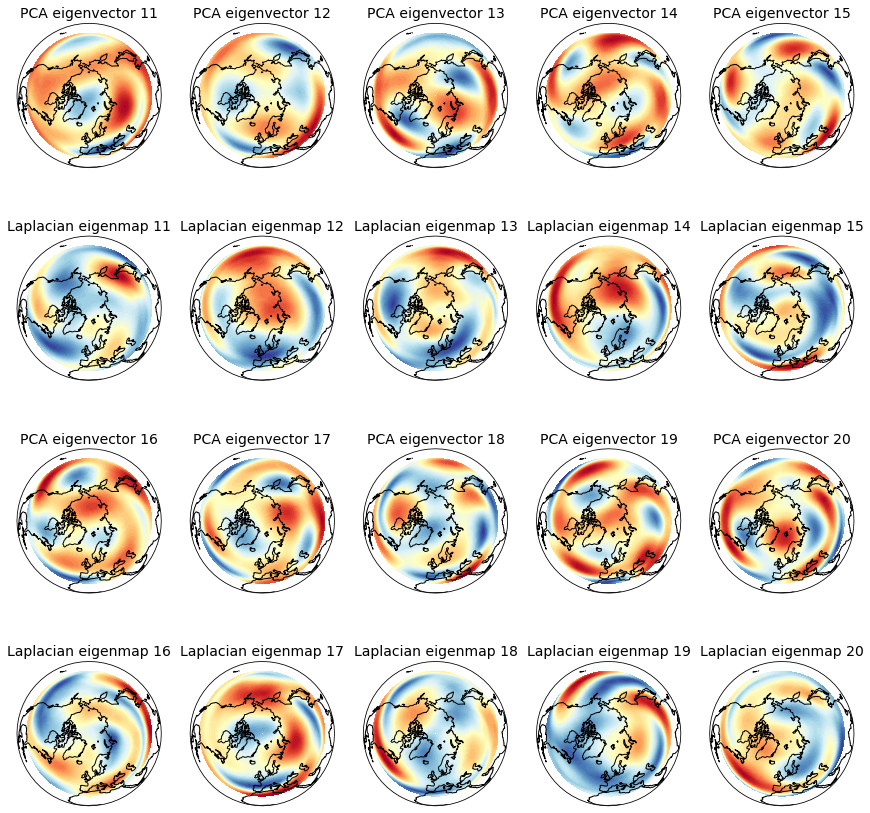

In [17]:
sign_PCA = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
sign_eigenmap = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
m,n = 10, 10
multiplot_PCA_eigenmap(components_pca_an,
                       basis_array,sign_PCA, sign_eigenmap,m,n,
                       DATA='anomalies',
                       PERC_NEIGH=10,
                       BDWTH='mean',
                       NUM_EIGENVALUES=20)

## Average patterns:

### Raw 1 vs 2: 

Load saved eigenvectors:

In [16]:
PATH1 = path_to_data('raw', PERC_NEIGH, BDWTH)
eig_1 = -np.load(PATH1 + 'eignpy_1.npy')
eig_2 = np.load(PATH1 + 'eignpy_2.npy')
winter_eig_1 = -np.load(PATH1 + 'winter_eignpy_1.npy')
winter_eig_2 = np.load(PATH1 + 'winter_eignpy_2.npy')
raw_cf = pd.read_csv(INPUT_DATA + 'raw_data_coefficients.csv', sep=',')

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/


Convert to time-series:

In [17]:
time = raw_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1), '2': np.real(eig_2)}, index = time)

Separate into regions on the plots:

In [25]:
part1 = df[df['1'] <= -0.00016]
part2 = df[df['2'].between(0.00005,0.0002)]
part2 = part2[part2['1'].between(-0.00013,-0.00005)]
part3 = df[df['2'].between(0.00000,0.0002)]
part3 = part3[part3['1'].between(-0.00005,0.00005)]
part4 = df[df['2'].between(0.0001,0.0002)]
part4 = part4[part4['1'].between(0.00008,0.00013)]
part5 = df[0.00019 < df['1']]
part6 = df[df['2'].between(-0.0001,-0.00005)]
part6 = part6[part6['1'].between(0.00008,0.00013)]
part7 = df[df['2'] < -0.00015]
part8 = df[df['2'].between(-0.0001,-0.00005)]
part8 = part8[part8['1'].between(-0.00013,-0.00005)]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

Plot the regions:

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


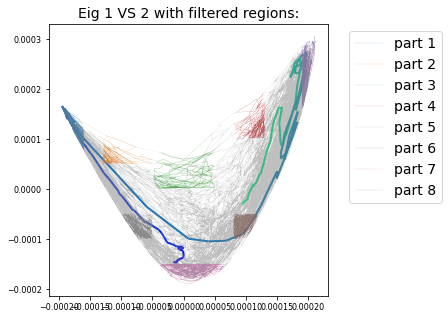

In [26]:
sample_trajectory = [winter_eig_1, winter_eig_2]
eigs = [np.real(eig_1), np.real(eig_2)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

Extract time values of these regions and compute mean over raw data over these times:

In [27]:
times = [filt_part.index for filt_part in regions]

df_mean = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

(141.37343417899515, 946.9162191515546)

Whole plot:

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Eigenvector 2')

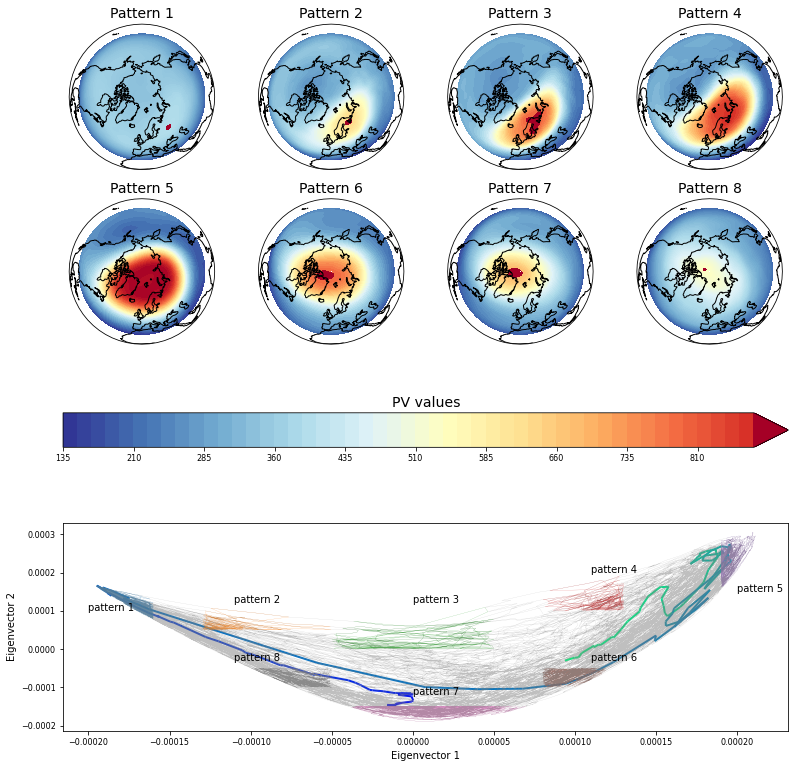

In [31]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)

annotations = [(-0.00020, 0.0001), (-0.00011, 0.00012), (0.000, 0.00012),
               (0.00011, 0.0002), (0.0002, 0.00015), (0.00011, -0.00003),
               (0.000, -0.00012), (-0.00011, -0.00003)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')
#plt.suptitle('Raw: eigenvector 1 VS 2')

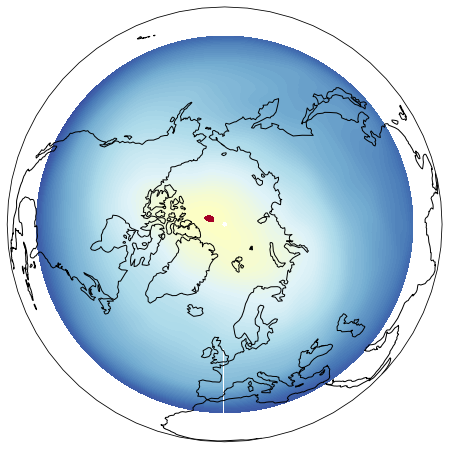

In [32]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [34]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/raweig1vs2.gif', images,duration=0.25)

### Raw 1 vs 5: 

In [35]:
PATH1 = path_to_data('raw', PERC_NEIGH, BDWTH)
eig_1 = -np.load(PATH1+'eignpy_1.npy')
eig_5 = -np.load(PATH1+'eignpy_5.npy')
winter_eig_1 = -np.load(PATH1+'winter_eignpy_1.npy')
winter_eig_5 = -np.load(PATH1+'winter_eignpy_5.npy')

Precise path: ../../../data/vandermeer/pickles/raw/10perc/t_mean/


In [36]:
time = raw_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1), '2': np.real(eig_5)}, index = time)

In [43]:
part1 = df[df['1'] <= -0.00017]
part2 = df[df['2'] <= -0.0003]
part2 = part2[part2['1'] <= -0.00005]
part2 = part2[part2['1'] >= -0.00015]
part3 = df[df['2'] <= -0.0003]
part3 = part3[part3['1'] <= 0.00005]
part3 = part3[part3['1'] >= 0]
part4 = df[df['2'] >= 0.0001]
part4 = part4[part4['1'] <= 0.00015]
part4 = part4[part4['1'] >= 0.0001]
part5 = df[df['1'] > 0.00017]
part5 = part5[part5['2'] > 0.0004]
part6 = df[df['2'] <= -0.0002]
part6 = part6[part6['1'] <= 0.00020]
part6 = part6[part6['1'] >= 0.00015]
part7 = df[df['2'] >= 0.0001]
part7 = part7[part7['1'] <= 0.00005]
part7 = part7[part7['1'] >= 0]
part8 = df[df['2'] >= 0.0001]
part8 = part8[part8['1'] <= -0.00005]
part8 = part8[part8['1'] >= -0.0001]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


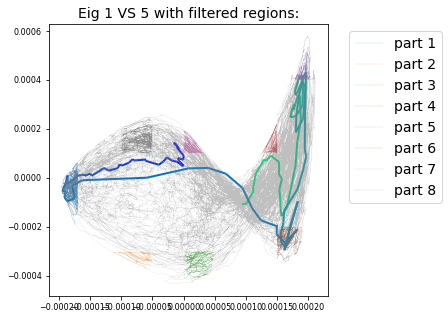

In [44]:
sample_trajectory = [winter_eig_1, winter_eig_5]
eigs = [np.real(eig_1), np.real(eig_5)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8)
plt.title('Eig 1 VS 5 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [45]:
times = [filt_part.index for filt_part in regions]

df_mean = raw_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

(117.98948866969236, 965.5667870792774)

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Eigenvector 5')

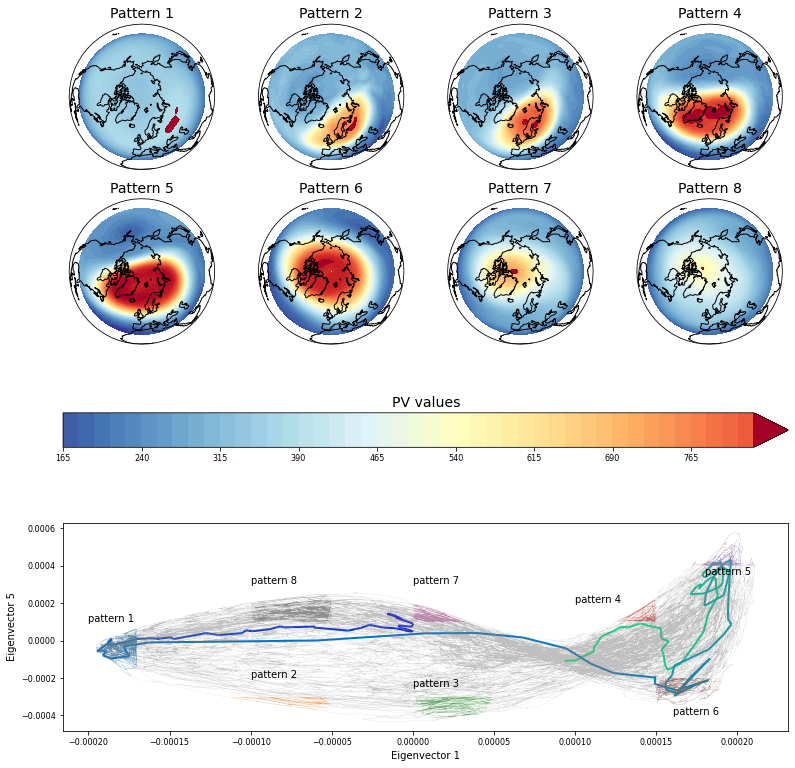

In [47]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 2:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)

annotations = [(-0.00020, 0.0001),
               (-0.0001, -0.0002), (0.0000, -0.00025),
               (0.0001, 0.0002), (0.00018, 0.00035), (0.00016, -0.0004),
               (0.000, 0.0003), (-0.0001, 0.0003)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 5')
#plt.suptitle('Raw: eigenvector 1 VS 2')

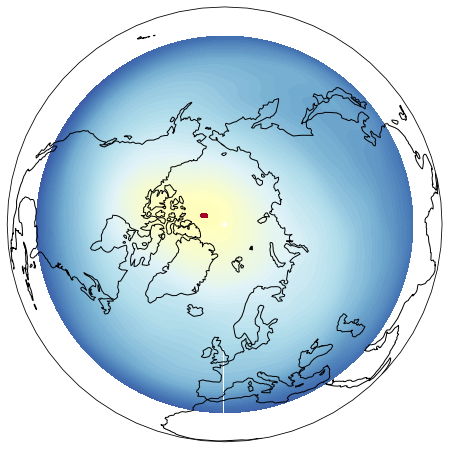

In [48]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [49]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/raweig1vs5.gif', images,duration=0.25)

### Anomalies 1 vs 4: 

In [50]:
PATH1 = path_to_data('anomalies', PERC_NEIGH, BDWTH)
eig_1_an = np.load(PATH1 + 'eignpy_an_1.npy')
eig_4_an = np.load(PATH1 + 'eignpy_an_4.npy')
anomalies_cf = pd.read_csv(INPUT_DATA + 'anomalies_coefficients.csv', sep=',')

winter_eig_1_an = np.load(PATH1+'winter_eignpy_1_an.npy')
winter_eig_4_an = np.load(PATH1+'winter_eignpy_4_an.npy')

df_mean = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

time = anomalies_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1_an), '2': np.real(eig_4_an)}, index = time)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/


In [51]:
part1 = df[-0.00005 < df['1']]
part1 = part1[part1['1'] <= 0.00005]
part1 = part1[part1['2'] >= 0.00015]
part2 = df[df['2'] >= 0.0001]
part2 = part2[part2['1'] >= -0.00020]
part2 = part2[part2['1'] <= -0.00015]
part3 = df[df['1'] <= -0.0003]
part3 = part3[part3['2'] <= -0.0001]
part4 = df[df['2'] <= -0.0002]
part4 = part4[part4['1'] >= -0.00020]
part4 = part4[part4['1'] <= -0.00015]
part5 = df[-0.00005 < df['1']]
part5 = part5[part5['1'] <= 0.00005]
part5 = part5[part5['2'] <= -0.0001]
part6 = df[df['2'] <= -0.0002]
part6 = part6[part6['1'] <= 0.00020]
part6 = part6[part6['1'] >= 0.00015]
part7 = df[0.0003 < df['1']]
part7 = part7[0.000 > part7['2']]
part8 = df[df['2'] >= 0.0001]
part8 = part8[part8['1'] <= 0.00020]
part8 = part8[part8['1'] >= 0.00015]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


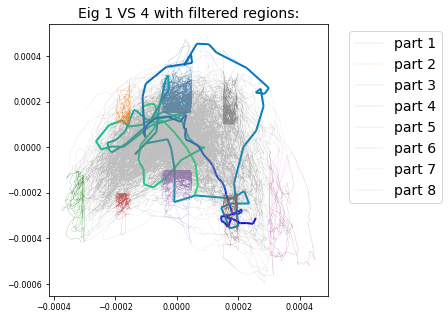

In [52]:
sample_trajectory = [winter_eig_1_an, winter_eig_4_an]
eigs = [np.real(eig_1_an), np.real(eig_4_an)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8, traj = True)
plt.title('Eig 1 VS 4 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [53]:
times = [filt_part.index for filt_part in regions]

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

(-2016651.7749454451, 2752041.290972501)

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Eigenvector 4')

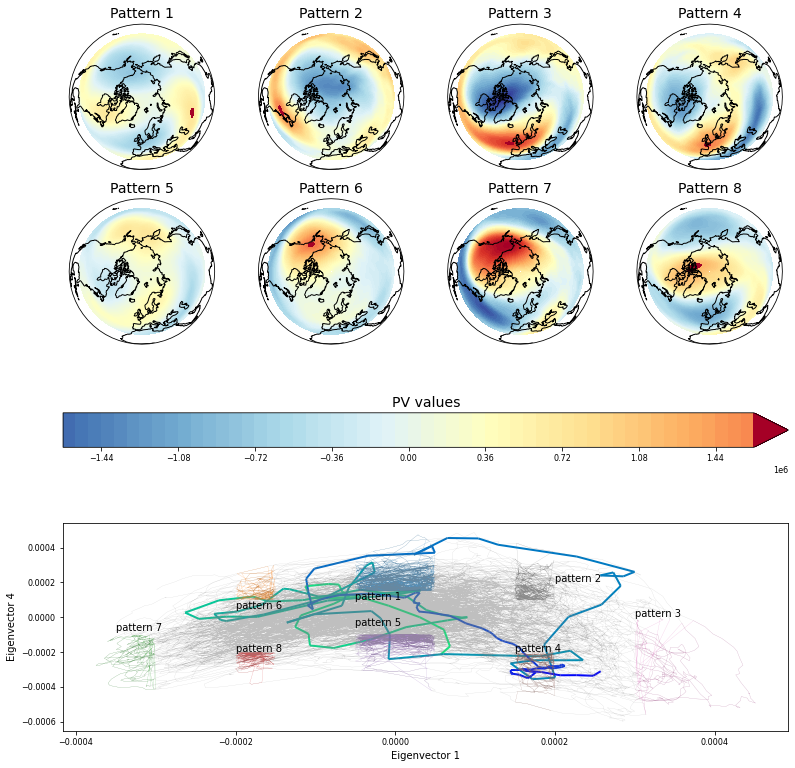

In [54]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)


annotations = [(-0.00005, 0.0001), (0.0002, 0.0002), (0.0003, 0.000),
               (0.00015, -0.0002), (-0.00005, -0.00005), (-0.00020, 0.00005),
               (-0.00035, -0.00008), (-0.00020, -0.0002)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 4')

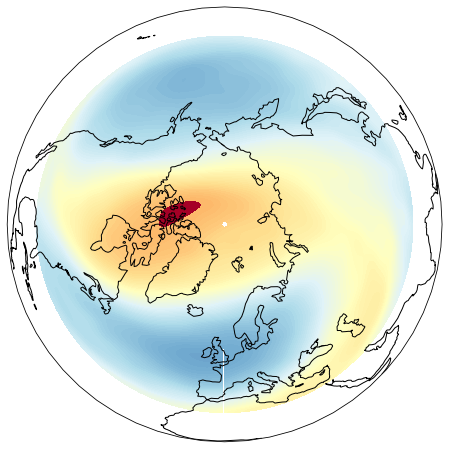

In [55]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [56]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/aneig1vs4.gif', images,duration=0.25)

### Anomalies 1 vs 2: 

In [57]:
PATH1 = path_to_data('anomalies', PERC_NEIGH, BDWTH)
eig_1_an = np.load(PATH1+'eignpy_an_1.npy')
eig_2_an = np.load(PATH1+'eignpy_an_2.npy')

winter_eig_1_an = np.load(PATH1+'winter_eignpy_1_an.npy')
winter_eig_2_an = np.load(PATH1+'winter_eignpy_2_an.npy')

time = anomalies_cf['Date']
time = pd.to_datetime(time)
df = pd.DataFrame(data = {'1': np.real(eig_1_an), '2': np.real(eig_2_an)}, index = time)
df_mean = anomalies_cf.drop(['Unnamed: 0', 'Date'], axis=1).set_index(time)

Precise path: ../../../data/vandermeer/pickles/anomalies/10perc/t_mean/


In [58]:
part7 = df[df['1'] <= -0.0002]
part7 = part7[part7['2'].between(-0.0001, 0.0001)]

part8 = df[df['1'].between(-0.0002, -0.0001)]
part8 = part8[part8['2'].between(0.0001, 0.0004)]

part1 = df[df['2'] >= 0.0002]
part1 = part1[part1['1'].between(-0.0001, 0.0001)]

part2 = df[df['1'].between(0.0001, 0.0002)]
part2 = part2[part2['2'].between(0.0001, 0.0004)]

part3 = df[df['1'] >= 0.0002]
part3 = part3[part3['2'].between(-0.0001, 0.0001)]

part4 = df[df['1'].between(0.0001, 0.0002)]
part4 = part4[part4['2'].between(-0.0004, -0.0001)]

part5 = df[df['2'] <= -0.0002]
part5 = part5[part5['1'].between(-0.0001, 0.0001)]

part6 = df[df['1'].between(-0.0002, -0.0001)]
part6 = part6[part6['2'].between(-0.0004, -0.0001)]

regions = [part1, part2, part3, part4, part5, part6,part7, part8]

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


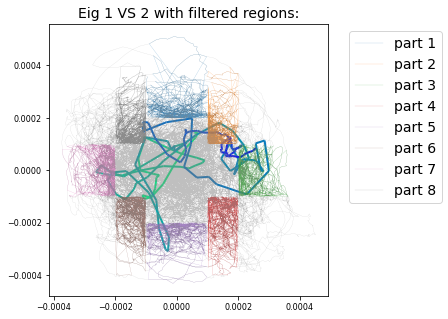

In [59]:
sample_trajectory = [winter_eig_1_an, winter_eig_2_an]
eigs = [np.real(eig_1_an), np.real(eig_2_an)]

fig = plt.figure(figsize=(5, 5))
ax1 = plt.subplot(1, 1, 1)
plot_regions(ax1, regions, sample_trajectory, eigs, alpha=0.8, traj = True)
plt.title('Eig 1 VS 2 with filtered regions:')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [60]:
times = [filt_part.index for filt_part in regions]

patterns = [np.mean(df_mean.loc[time].values, axis=0) for time in times]

values, latitudes, longitudes= [], [],[]

for i in range(len(patterns)):
    values_array, lat, lon = create_geo_sample(np.multiply(patterns[i],1e6), basis_array)
    values.append(values_array)
    latitudes.append(lat)
    longitudes.append(lon)
    
vmin = np.min(np.array(values))
vmax = np.max(np.array(values))
vmin, vmax

(-1404364.5579344495, 1781801.6066928052)

/home/vandermeer/anaconda3/envs/test_cartopy_install/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Eigenvector 2')

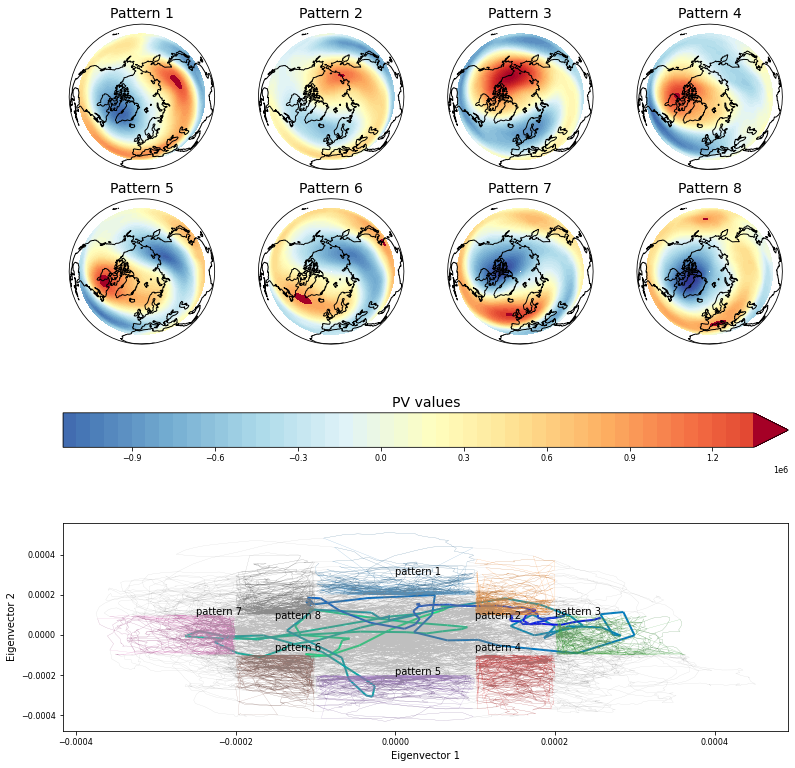

In [61]:
projection = ccrs.Orthographic(central_longitude=0.0, central_latitude=90.0)
data_crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(13, 13))

# Plot average patterns:
axs = [
    plt.subplot(3, 4, i + 1, projection=projection)
    for i in range(len(patterns))
]

for i in range(len(patterns)):
    axs[i].set_title(f'Pattern {i+1}')
    axs[i].set_global()
    axs[i].coastlines()
    values_array, latitude, longitude = values[i], latitudes[i], longitudes[i]
    if i == 3:
        pcm = axs[i].contourf(longitude,
                              latitude,
                              values_array,
                              60,
                              transform=data_crs,
                              cmap='RdYlBu_r',
                              vmin=vmin,
                              vmax=vmax,
                              extend='max')
    else:
        axs[i].contourf(longitude,
                        latitude,
                        values_array,
                        60,
                        transform=data_crs,
                        cmap='RdYlBu_r',
                        vmin=vmin,
                        vmax=vmax,
                        extend='max')
ax9 = plt.subplot(313)
plot_regions(ax9, regions, sample_trajectory, eigs)

annotations = [(0.0000, 0.0003), (0.0001, 0.00008), (0.0002, 0.0001),
               (0.0001, -0.00008), (0.0000, -0.0002), (-0.00015, -0.00008),
               (-0.00025, 0.0001), (-0.00015, 0.00008)]

for i in range(len(patterns)):
    ax9.annotate(f'pattern {i+1}', xy=annotations[i])

clb = fig.colorbar(pcm, ax=axs, location='bottom')
clb.ax.set_title('PV values')
ax9.set_xlabel('Eigenvector 1')
ax9.set_ylabel('Eigenvector 2')

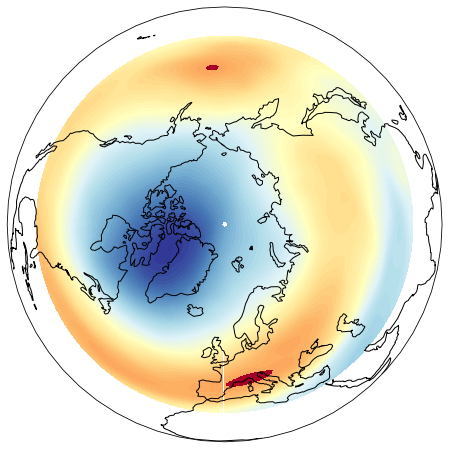

In [62]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot(111, projection=projection)
ax1.set_global()
ax1.coastlines()

for i in range(len(patterns)):
    lon, lat, values_array = longitudes[i], latitudes[i], values[i]
    ax1.contourf(lon,
                 lat,
                 values_array,
                 60,
                 transform=data_crs,
                 cmap='RdYlBu_r',
                 vmin=vmin,
                 vmax=vmax,
                 extend='max')
    plt.savefig(f'gif/image{i}.png')

In [ ]:
import imageio
images = []
filenames  =[]
for i in range(len(patterns)):
    filenames.append(f'gif/image{i}.png')

for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('gif/aneig1vs2.gif', images,duration=0.25)